In [2]:
import os 
os.chdir("../..")

In [3]:
import numpy as np
import json
from detectron2.structures import BoxMode
import pandas as pd
import geopandas as gpd
import cv2
import matplotlib.pyplot as plt


from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from src.utils.dataset import split_train_val_test, get_detectron2_dataset_dicts#, #register_detectron2_datasets
import pickle

In [35]:
import os
import cv2
import pandas as pd
import geopandas as gpd
import numpy as np

from functools import partial

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

from sklearn.model_selection import train_test_split


def split_train_val_test(samples, train_ratio, val_ratio, test_ratio=None):
    test_ratio = test_ratio or (1.0 - train_ratio - val_ratio)
    assert 0 < train_ratio < 1
    assert 0 < val_ratio < 1
    assert 0 < test_ratio < 1
    assert 0 < train_ratio + val_ratio + test_ratio <=1

    train, valtest = train_test_split(samples, train_size=train_ratio)
    val, test = train_test_split(
        valtest, train_size=val_ratio / (val_ratio + test_ratio))

    return {"train": train,
            "val": val,
            "test": test}


def _convert_single_bbox(bbox):
    py, px = bbox.exterior.xy
    return {"bbox": [int(min(px)), int(min(py)),
                     int(max(px)), int(max(py))],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": 0}


def _convert_single_patch(patch_df, images_dir,image_shape=(256, 256)):
    patch_number = patch_df["patch_number"].iloc[0]
    file_path = os.path.join(images_dir, f"patch_{patch_number}.png")
    image_shape = image_shape or cv2.imread(file_path).shape[:2]
    return {"file_name": file_path,
            "image_id": patch_number,
            "height": image_shape[0],
            "width": image_shape[1],
            "annotations": patch_df["bbox"].apply(_convert_single_bbox).tolist()}


# def get_detectron2_dataset_dicts(images_dir, patches_subset, min_bbox_area=100,
#                                  limit_train=-1, limit_val=-1, limit_test=-1):

   


In [4]:
images_dir = "./data/szprotawa/szprotawa_patches_256/"
min_bbox_area = 400

annotations = pd.read_pickle(f"{images_dir}/annotation.pkl").set_geometry("bbox")

splits = split_train_val_test(annotations["patch_number"].unique(), 0.7, 0.15, 0.15)
patches_subset = splits['test']

In [66]:
annotations = annotations[annotations["bbox"].area >= min_bbox_area]
annotations = annotations[annotations["patch_number"].isin(patches_subset)]

In [67]:
g = annotations.groupby("patch_number")

In [6]:
dataset_dicts = get_detectron2_dataset_dicts(images_dir, splits["val"], min_bbox_area=200)#g.apply(_convert_single_patch, images_dir=images_dir, image_shape=(256,256)).tolist()

In [7]:
DatasetCatalog.register("szp_test3", lambda: dataset_dicts)

In [8]:
MetadataCatalog.get("szp_test3").set(thing_classes=["SickTrees"])

Metadata(name='szp_test3', thing_classes=['SickTrees'])

In [9]:
# dataset_dicts = get_szprotawa_dicts("data/szprotawa_patches_256/")
# dataset_dicts = DatasetCatalog.get("szprotawa_train")

In [10]:
meta = MetadataCatalog.get("szp_test3")

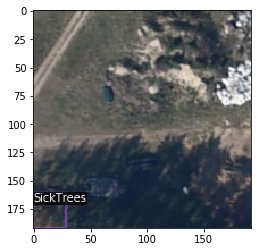

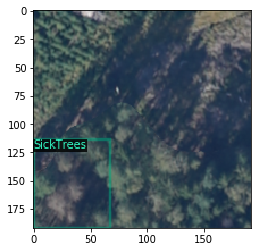

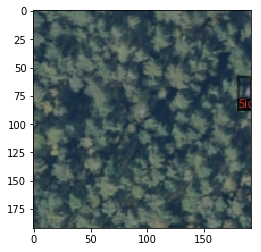

In [20]:
smpl = np.random.choice(dataset_dicts, 3)
for d in smpl:
    img = cv2.imread(d["file_name"])[:, :, ::-1]
    visualizer = Visualizer(img, metadata=meta, 
                            scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [6]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [8]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [9]:
from datetime import datetime


In [10]:
cfg = get_cfg()

cfg.OUTPUT_DIR = f"./tboard_logs/retinanet {datetime.now().isoformat().rsplit(':', 1)[0]}/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("szprotawa_train",)
cfg.DATASETS.TEST = ("szprotawa_val",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10_000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset

cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.RETINANET.NUM_CLASSES = 1  # only has one class (ballon)

cfg.TEST.EVAL_PERIOD = 0#2_000 #200
cfg.TEST.DETECTIONS_PER_IMAGE = 5

cfg.VIS_PERIOD = 100

Loading config /home/mkosturek/miniconda3/envs/geopython37/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [32]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


class Trainer(DefaultTrainer):
    
    
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR+"/eval/")



In [33]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/20 20:14:04 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

'head.cls_score.weight' has shape (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! Skipped.
'head.cls_score.bias' has shape (720,) in the checkpoint but (9,) in the model! Skipped.


[01/20 20:15:05 d2.engine.train_loop]: Starting training from iteration 0
[01/20 20:15:05 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


TypeError: build_evaluator() missing 1 required positional argument: 'dataset_name'

In [86]:
cfg.OUTPUT_DIR

'./output/retinanet/'

In [24]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("szprotawa_val", )
cfg.TEST.SCORE_THRESHOLD = 0.3
cfg.TEST.SCORE_THRESH = 0.3

cfg.TEST.DETECTIONS_PER_IMAGE = 10
predictor = DefaultPredictor(cfg)

predictor.cfg["TEST"]

CfgNode({'EXPECTED_RESULTS': [], 'EVAL_PERIOD': 200, 'KEYPOINT_OKS_SIGMAS': [], 'DETECTIONS_PER_IMAGE': 10, 'AUG': CfgNode({'ENABLED': False, 'MIN_SIZES': (400, 500, 600, 700, 800, 900, 1000, 1100, 1200), 'MAX_SIZE': 4000, 'FLIP': True}), 'PRECISE_BN': CfgNode({'ENABLED': False, 'NUM_ITER': 200}), 'SCORE_THRESHOLD': 0.3, 'SCORE_THRESH': 0.3})

In [12]:
1+2

3

In [9]:
from detectron2.utils.visualizer import ColorMode
# dataset_dicts = DatasetCatalog.get("szprotawa_val")

In [12]:

for d in np.random.choice(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1].copy(),
                   metadata=meta, 
                   scale=0.8)
    vis = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    f, a = plt.subplots(1,2, figsize=(10,5))
    a[0].imshow(vis.get_image())
    
    v = Visualizer(im[:,:,::-1].copy(),
                   metadata=meta, 
                   scale=0.8)
    vis = v.draw_dataset_dict(d)
    a[1].imshow(vis.get_image())

NameError: name 'dataset_dicts' is not defined

In [23]:
_ = register_detectron2_datasets("szprott", "./data/szprotawa_patches_256/", 0.7, 0.15, 0.15, 100, {'test': splits['test'][:500]})

In [25]:
from detectron2.evaluation import DatasetEvaluator, COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader



evaluator = COCOEvaluator("szprottx_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "szprott_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [01/18 23:06:37 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'szprott_test'
[01/18 23:06:37 d2.data.datasets.coco]: Converting dataset annotations in 'szprott_test' to COCO format ...)
[01/18 23:06:48 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/18 23:06:48 d2.data.datasets.coco]: Conversion finished, num images: 475, num annotations: 552
[01/18 23:06:48 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/retinanet2/szprott_test_coco_format.json
[01/18 23:06:52 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| sick_trees | 552          |
|            |              |
[01/18 23:06:52 d2.evaluation.evaluator]: Start inference on 475 images
[01/18 23:06:55 d2.evaluation.evaluator]: Inference done 11/475. 0.1989 s / img. ETA=0:01:33
[01/18 23:07:00 d2.evaluation.evaluator]: Inference done 36/475. 0.2001 s / img. ETA=0:01:29
[01/18

OrderedDict([('bbox',
              {'AP': 15.079148987151548,
               'AP50': 42.51173431940811,
               'AP75': 6.380618287890169,
               'APs': 9.7137150659163,
               'APm': 18.6626573904591,
               'APl': 22.355839030534156})])

In [ ]:
1+2

In [38]:
outputs.keys()

dict_keys(['instances'])